In [30]:
import yaml
import pandas as pd
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))
from config import *

trace_list = []
with open('../../traces/trace_combinations.txt', "r") as f:
  for line in f:
    trace_list.append(line.strip().split(','))
mpki_list = {}

with open('../../traces/mpki.csv', "r") as f:
  for line in f:
    trace = line.strip().split(',')[0] 
    mpki = line.strip().split(',')[1]
    mpki_list[trace] = float(mpki)

data_rows = []
for trace_group in trace_list:
  for device in device_list:
    for org in org_list[device]:
      for timing in timing_list[device]:
        for row_policy in row_policy_list[device]:
          for refresh_manager in refresh_manager_list[device]:
            for area_scale in area_scaling_list[device]:
              for voltage_scale in voltage_scaling_list[device]:
                run_file = f'{device}_{org}_{timing}_{row_policy}_{refresh_manager}_{area_scale}_{voltage_scale}_{trace_group[0]}'
                with open(f'../../results/stats/{run_file}.yaml', 'r') as f:
                  data_rows.append({
                    'Device': device,
                    'Org': org,
                    'Timing': timing,
                    'Row Policy': row_policy,
                    'Refresh Manager': refresh_manager,
                    'Area Scaling': area_scale,
                    'Voltage Scaling': voltage_scale,
                    'Trace': trace_group[0],
                    'Yaml': yaml.safe_load(f)
                  })

df = pd.DataFrame(data_rows)
sc_df = df[~df['Trace'].str.startswith(tuple(['H', 'L']))].copy() #singlecore run results
sc_df.loc[:, 'MPKI'] = sc_df['Trace'].apply(lambda x: mpki_list[x])
sc_df.sort_values(by='MPKI', inplace=True)
sc_df.reset_index(drop=True, inplace=True)

mc_df = df[df['Trace'].str.startswith(tuple(['H', 'L']))].copy()  #multicore run results
mc_df.sort_values(by='Trace', ascending=False, inplace=True)

### Singelcore Plots

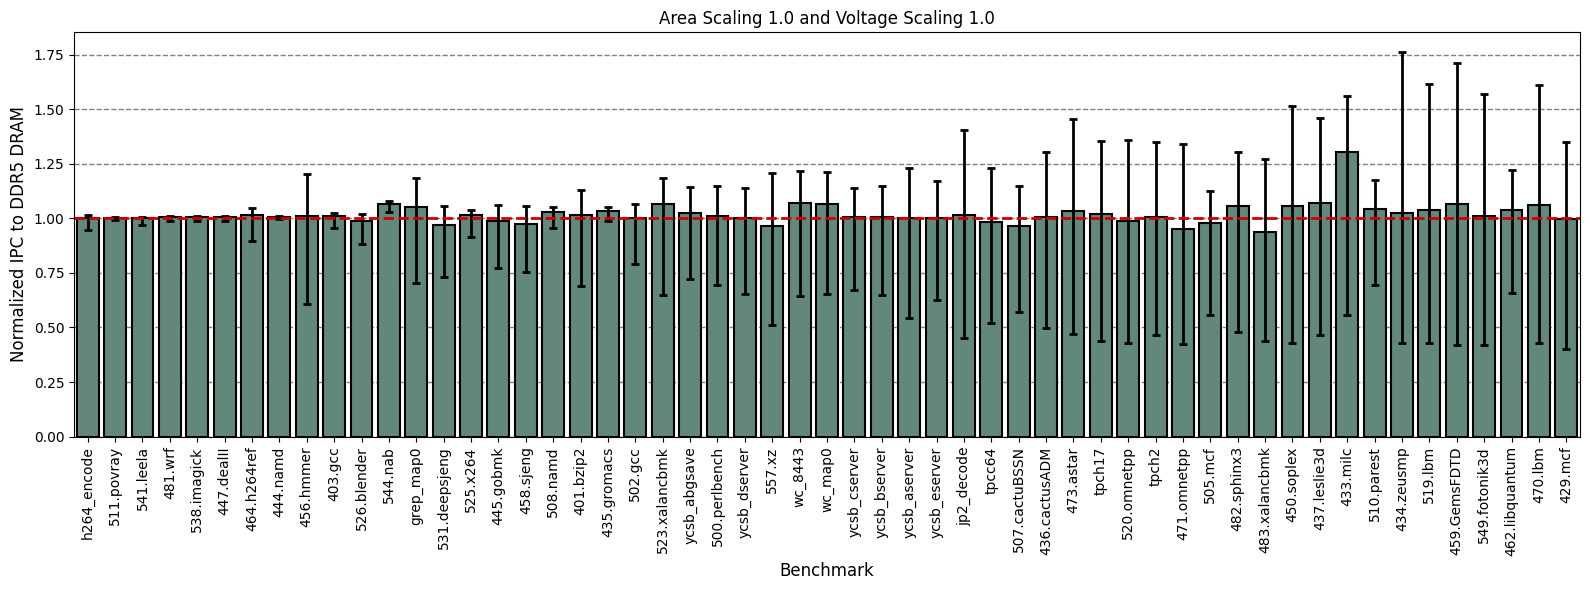

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

color_palette =['#5B8E7D']

# metric to work with
sc_df.loc[:, 'IPC'] = sc_df['Yaml'].apply(lambda x: x['Frontend']['num_expected_insts'] / x['Frontend']['cycles_recorded_core_0'])

uram5_df = sc_df[(sc_df['Device'] == 'URAM5') & (sc_df['Row Policy'] == 'OpenRowPolicy')]
ddr5_df  = sc_df[(sc_df['Device'] == 'DDR5' ) & (sc_df['Row Policy'] == 'OpenRowPolicy') & (sc_df['Area Scaling'] == 1.0) & (sc_df['Voltage Scaling'] == 1.0)]

combined_df = pd.merge(uram5_df[['Trace', 'Area Scaling', 'Voltage Scaling', 'IPC']],
                       ddr5_df[['Trace', 'Area Scaling', 'Voltage Scaling', 'IPC']],
                       on='Trace', suffixes=(' URAM5', ' DDR5'))
combined_df['Normalized IPC'] = combined_df['IPC URAM5'] / combined_df['IPC DDR5']
combined_df = combined_df[['Trace', 'Area Scaling URAM5', 'Voltage Scaling URAM5', 'Normalized IPC']]

# for error lines in the plot (i.e., min, mean, max values)
error_df = combined_df.groupby('Trace')['Normalized IPC'].agg(['min', 'mean', 'max']).reset_index()
error_df = error_df.set_index('Trace').reindex(combined_df['Trace'].drop_duplicates().values).reset_index()

# for bars in the plot (i.e., values from area_scaling=1.0 and voltage_scaling=1.0)
base_df = combined_df[(combined_df['Area Scaling URAM5'] == 1.0) & 
                          (combined_df['Voltage Scaling URAM5'] == 1.0)]

#-------------------------------------------------------------------------------

plt.figure(figsize=(16, 6))

barplot = sns.barplot(data=base_df, x='Trace', y='Normalized IPC', edgecolor='black', 
                      linewidth=1.5, color=color_palette[0], zorder=2)

bar_positions = barplot.get_xticks()
for i, row in error_df.iterrows():
  barplot.errorbar(x=bar_positions[i], y=row['mean'], 
                    yerr=[[row['mean'] - row['min']], [row['max'] - row['mean']]], 
                    fmt='none', color='black', capsize=3, capthick=2, elinewidth=2)

barplot.set_xlabel('Benchmark', fontsize=12)
barplot.set_ylabel('Normalized IPC to DDR5 DRAM', fontsize=12)
barplot.set_title(f'Area Scaling 1.0 and Voltage Scaling 1.0', fontsize=12)
barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=1, color='gray', zorder=0)

barplot.axhline(y=1.0, color='#d00000', linestyle='--', linewidth=2)
barplot.set_xlim(-0.5, len(base_df['Trace']) - 0.5)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

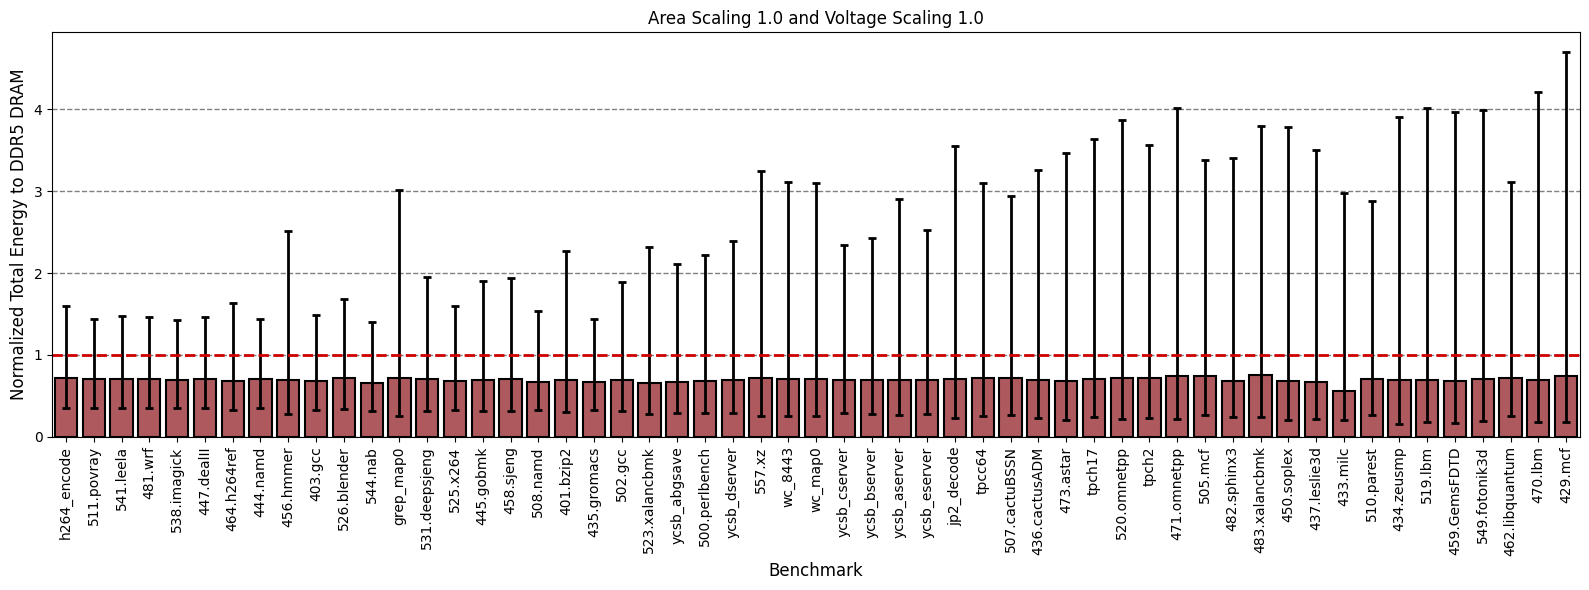

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

color_palette =['#BC4B51']

sc_df.loc[:, 'Total Energy'] = sc_df['Yaml'].apply(lambda x: x['MemorySystem']['DRAM']['total_energy'])

uram5_df = sc_df[(sc_df['Device'] == 'URAM5') & (sc_df['Row Policy'] == 'OpenRowPolicy')]
ddr5_df  = sc_df[(sc_df['Device'] == 'DDR5' ) & (sc_df['Row Policy'] == 'OpenRowPolicy') & (sc_df['Area Scaling'] == 1.0) & (sc_df['Voltage Scaling'] == 1.0)]

combined_df = pd.merge(uram5_df[['Trace', 'Area Scaling', 'Voltage Scaling', 'Total Energy']],
                       ddr5_df[['Trace', 'Area Scaling', 'Voltage Scaling', 'Total Energy']], on='Trace', suffixes=(' URAM5', ' DDR5'))
combined_df['Normalized Total Energy'] = combined_df['Total Energy URAM5'] / combined_df['Total Energy DDR5']
combined_df = combined_df[['Trace', 'Area Scaling URAM5', 'Voltage Scaling URAM5', 'Normalized Total Energy']]

error_df = combined_df.groupby('Trace')['Normalized Total Energy'].agg(['min', 'mean', 'max']).reset_index()
error_df = error_df.set_index('Trace').reindex(combined_df['Trace'].drop_duplicates().values).reset_index()

base_df = combined_df[(combined_df['Area Scaling URAM5'] == 1.0) & 
                          (combined_df['Voltage Scaling URAM5'] == 1.0)]

#-------------------------------------------------------------------------------

plt.figure(figsize=(16, 6))

barplot = sns.barplot(data=base_df, x='Trace', y='Normalized Total Energy', edgecolor='black', 
                      linewidth=1.5, color=color_palette[0], zorder=2)

bar_positions = barplot.get_xticks()
for i, row in error_df.iterrows():
  barplot.errorbar(x=bar_positions[i], y=row['mean'], 
                    yerr=[[row['mean'] - row['min']], [row['max'] - row['mean']]], 
                    fmt='none', color='black', capsize=3, capthick=2, elinewidth=2)


barplot.set_xlabel('Benchmark', fontsize=12)
barplot.set_ylabel('Normalized Total Energy to DDR5 DRAM', fontsize=12)
barplot.set_title(f'Area Scaling 1.0 and Voltage Scaling 1.0', fontsize=12)
barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=1, color='gray', zorder=0)

barplot.axhline(y=1.0, color='#d00000', linestyle='--', linewidth=2)
barplot.set_xlim(-0.5, len(base_df['Trace']) - 0.5)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Multicore Plots

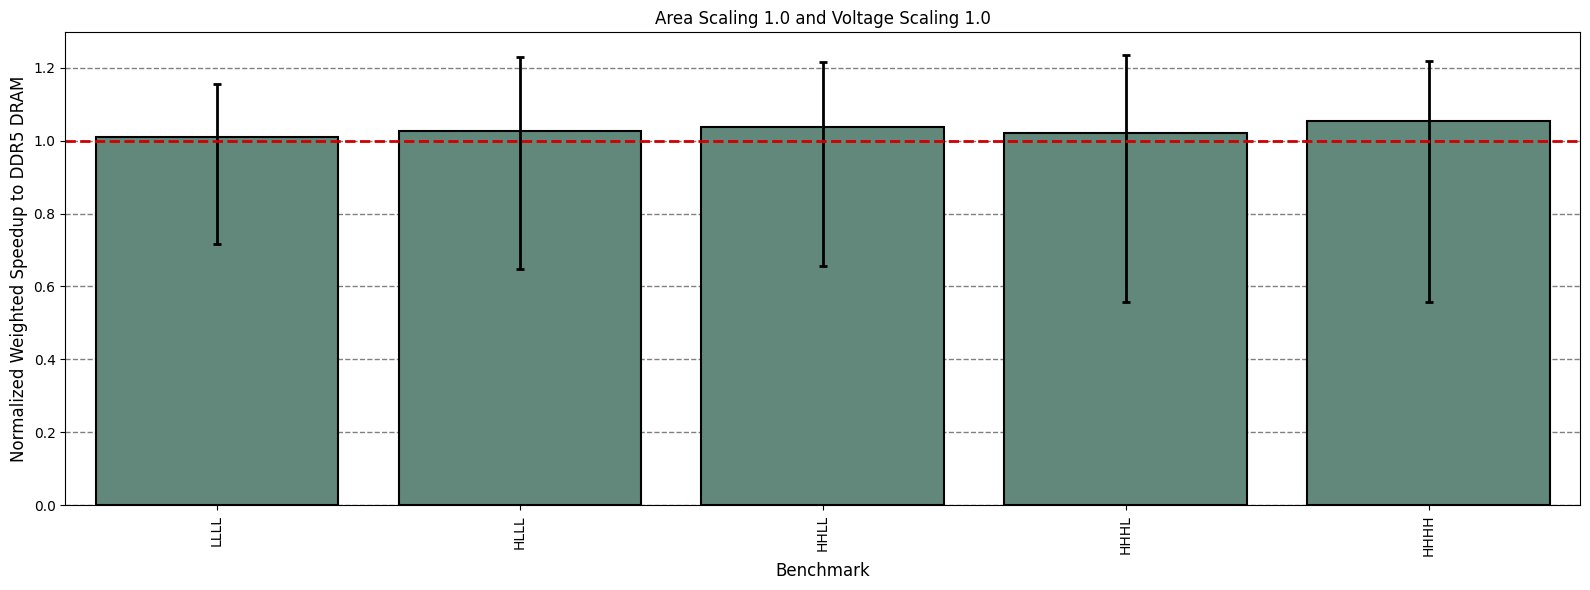

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

color_palette =['#5B8E7D']
trace_groups = {trace[0]: trace[1:] for trace in trace_list if trace[0].startswith(('H', 'L', 'M'))}

mc_df.loc[:, 'Weighted Speedup'] = 0.0

for index, rows in mc_df.iterrows():
  weighted_ipc = 0.0
  mc_trace_ipc = 0.0
  for idx, trace in enumerate(trace_groups[rows['Trace']]):
    conditions = (
      (sc_df['Device'] == 'DDR5') &
      (sc_df['Org'] == rows['Org']) &
      (sc_df['Timing'] == rows['Timing']) &
      (sc_df['Row Policy'] == rows['Row Policy']) &
      (sc_df['Refresh Manager'] == 'AllBank') &
      (sc_df['Voltage Scaling'] == 1.0) &
      (sc_df['Area Scaling'] == 1.0) &
      (sc_df['Trace'] == trace)
    )
    mc_trace_ipc = rows['Yaml']['Frontend']['num_expected_insts'] / rows['Yaml']['Frontend'][f'cycles_recorded_core_{idx}']
    sc_trace_ipc = sc_df[conditions]['Yaml'].item()['Frontend']['num_expected_insts'] / sc_df[conditions]['Yaml'].item()['Frontend']['cycles_recorded_core_0']
    weighted_ipc += mc_trace_ipc / sc_trace_ipc
  mc_df.at[index, 'Weighted Speedup'] = weighted_ipc

# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------

uram5_df = mc_df[(mc_df['Device'] == 'URAM5') & (mc_df['Row Policy'] == 'OpenRowPolicy')]
ddr5_df  = mc_df[(mc_df['Device'] == 'DDR5' ) & (mc_df['Row Policy'] == 'OpenRowPolicy') & (mc_df['Area Scaling'] == 1.0) & (mc_df['Voltage Scaling'] == 1.0)]

combined_df = pd.merge(uram5_df[['Trace', 'Area Scaling', 'Voltage Scaling', 'Weighted Speedup']],
                       ddr5_df[['Trace', 'Area Scaling', 'Voltage Scaling', 'Weighted Speedup']], on='Trace', suffixes=(' URAM5', ' DDR5'))
combined_df['Normalized Weighted Speedup'] = combined_df['Weighted Speedup URAM5'] / combined_df['Weighted Speedup DDR5']
combined_df = combined_df[['Trace', 'Area Scaling URAM5', 'Voltage Scaling URAM5', 'Normalized Weighted Speedup']]

error_df = combined_df.groupby('Trace')['Normalized Weighted Speedup'].agg(['min', 'mean', 'max']).reset_index()
error_df = error_df.set_index('Trace').reindex(combined_df['Trace'].drop_duplicates().values).reset_index()
base_df = combined_df[(combined_df['Area Scaling URAM5'] == 1.0) &  (combined_df['Voltage Scaling URAM5'] == 1.0)].copy()

base_df.loc[:, 'Trace Prefix'] = base_df['Trace'].str.extract(r'([A-Za-z]+)', expand=False)
agg_base_df = base_df.groupby('Trace Prefix').sum().reset_index()
agg_base_df['Normalized Weighted Speedup'] =  agg_base_df['Normalized Weighted Speedup'] / 20 #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_base_df.sort_values(by='Trace Prefix', ascending=False, inplace=True)

error_df.loc[:, 'Trace Prefix'] = error_df['Trace'].str.extract(r'([A-Za-z]+)', expand=False)
agg_error_df = error_df.groupby('Trace Prefix').sum().reset_index()
agg_error_df['max'] = agg_error_df['max'] / 20  #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_error_df['mean'] = agg_error_df['mean'] / 20  #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_error_df['min'] = agg_error_df['min'] / 20  #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_error_df = agg_error_df.set_index('Trace Prefix').reindex(agg_base_df['Trace Prefix'].drop_duplicates().values).reset_index()

#-------------------------------------------------------------------------------

plt.figure(figsize=(16, 6))

barplot = sns.barplot(data=agg_base_df, x='Trace Prefix', y='Normalized Weighted Speedup', edgecolor='black', 
                      linewidth=1.5, color=color_palette[0], zorder=2)

bar_positions = barplot.get_xticks()
for i, row in agg_error_df.iterrows():
  barplot.errorbar(x=bar_positions[i], y=row['mean'], 
                    yerr=[[row['mean'] - row['min']], [row['max'] - row['mean']]], 
                    fmt='none', color='black', capsize=3, capthick=2, elinewidth=2)

barplot.set_xlabel('Benchmark', fontsize=12)
barplot.set_ylabel('Normalized Weighted Speedup to DDR5 DRAM', fontsize=12)
barplot.set_title(f'Area Scaling 1.0 and Voltage Scaling 1.0', fontsize=12)
barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=1, color='gray', zorder=0)

barplot.axhline(y=1.0, color='#d00000', linestyle='--', linewidth=2)
barplot.set_xlim(-0.5, len(agg_base_df['Trace']) - 0.5)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


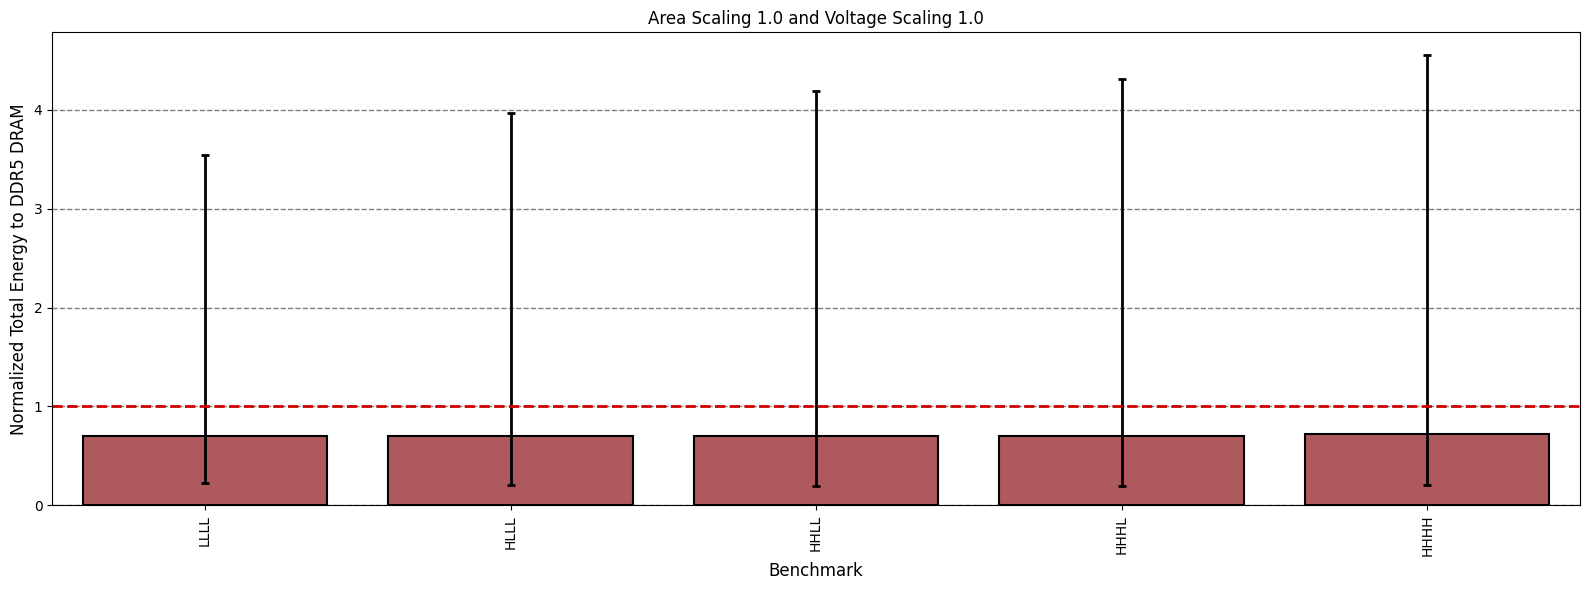

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

color_palette =['#BC4B51']
trace_groups = {trace[0]: trace[1:] for trace in trace_list if trace[0].startswith(('H', 'L', 'M'))}

mc_df.loc[:, 'Total Energy'] = mc_df['Yaml'].apply(lambda x: x['MemorySystem']['DRAM']['total_energy'])

uram5_df = mc_df[(mc_df['Device'] == 'URAM5') & (mc_df['Row Policy'] == 'OpenRowPolicy')]
ddr5_df  = mc_df[(mc_df['Device'] == 'DDR5' ) & (mc_df['Row Policy'] == 'OpenRowPolicy') & (mc_df['Area Scaling'] == 1.0) & (mc_df['Voltage Scaling'] == 1.0)]

combined_df = pd.merge(uram5_df[['Trace', 'Area Scaling', 'Voltage Scaling', 'Total Energy']],
                       ddr5_df[['Trace', 'Area Scaling', 'Voltage Scaling', 'Total Energy']], on='Trace', suffixes=(' URAM5', ' DDR5'))
combined_df['Normalized Total Energy'] = combined_df['Total Energy URAM5'] / combined_df['Total Energy DDR5']
combined_df = combined_df[['Trace', 'Area Scaling URAM5', 'Voltage Scaling URAM5', 'Normalized Total Energy']]

error_df = combined_df.groupby('Trace')['Normalized Total Energy'].agg(['min', 'mean', 'max']).reset_index()
error_df = error_df.set_index('Trace').reindex(combined_df['Trace'].drop_duplicates().values).reset_index()
base_df = combined_df[(combined_df['Area Scaling URAM5'] == 1.0) & (combined_df['Voltage Scaling URAM5'] == 1.0)].copy()

base_df.loc[:, 'Trace Prefix'] = base_df['Trace'].str.extract(r'([A-Za-z]+)', expand=False)
agg_base_df = base_df.groupby('Trace Prefix').sum().reset_index()
agg_base_df['Normalized Total Energy'] =  agg_base_df['Normalized Total Energy'] / 20 #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_base_df.sort_values(by='Trace Prefix', ascending=False, inplace=True)

error_df.loc[:, 'Trace Prefix'] = error_df['Trace'].str.extract(r'([A-Za-z]+)', expand=False)
agg_error_df = error_df.groupby('Trace Prefix').sum().reset_index()
agg_error_df['max'] = agg_error_df['max'] / 20  #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_error_df['mean'] = agg_error_df['mean'] / 20  #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_error_df['min'] = agg_error_df['min'] / 20  #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_error_df = agg_error_df.set_index('Trace Prefix').reindex(agg_base_df['Trace Prefix'].drop_duplicates().values).reset_index()

#-------------------------------------------------------------------------------

plt.figure(figsize=(16, 6))

barplot = sns.barplot(data=agg_base_df, x='Trace Prefix', y='Normalized Total Energy', edgecolor='black', 
                      linewidth=1.5, color=color_palette[0], zorder=2)

bar_positions = barplot.get_xticks()
for i, row in agg_error_df.iterrows():
  barplot.errorbar(x=bar_positions[i], y=row['mean'], 
                    yerr=[[row['mean'] - row['min']], [row['max'] - row['mean']]], 
                    fmt='none', color='black', capsize=3, capthick=2, elinewidth=2)

barplot.set_xlabel('Benchmark', fontsize=12)
barplot.set_ylabel('Normalized Total Energy to DDR5 DRAM', fontsize=12)
barplot.set_title(f'Area Scaling 1.0 and Voltage Scaling 1.0', fontsize=12)
barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=1, color='gray', zorder=0)

barplot.axhline(y=1.0, color='#d00000', linestyle='--', linewidth=2)
barplot.set_xlim(-0.5, len(agg_base_df['Trace Prefix']) - 0.5)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### refresh related

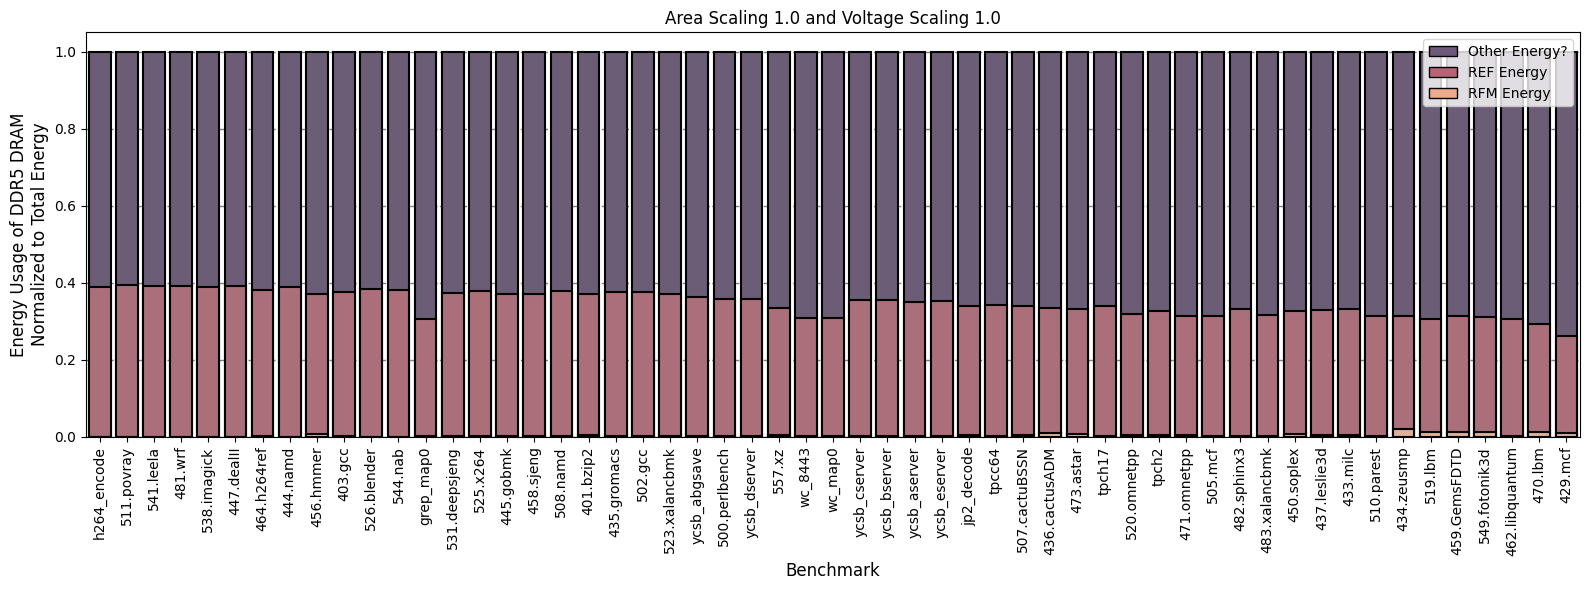

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

color_palette =['#6d597a', '#b56576', '#eaac8b']

ddr5_df = sc_df[(sc_df['Device'] == 'DDR5' ) & (sc_df['Row Policy'] == 'OpenRowPolicy') & (sc_df['Area Scaling'] == 1.0) & (sc_df['Voltage Scaling'] == 1.0)].copy()
ddr5_df.loc[:, 'Normalized Total RFM Energy'] = ddr5_df['Yaml'].apply(lambda x: x['MemorySystem']['DRAM']['total_rfm_energy'] / x['MemorySystem']['DRAM']['total_energy'])
ddr5_df.loc[:, 'Normalized Total REF Energy'] = ddr5_df['Yaml'].apply(lambda x: x['MemorySystem']['DRAM']['total_ref_energy'] / x['MemorySystem']['DRAM']['total_energy'])
ddr5_df.loc[:, 'Normalized Total REF Energy'] = ddr5_df['Normalized Total REF Energy'] + ddr5_df['Normalized Total RFM Energy']
ddr5_df.loc[:, 'Normalized Total Energy']     = 1.0
ddr5_df = ddr5_df[['Trace', 'Normalized Total Energy', 'Normalized Total REF Energy', 'Normalized Total RFM Energy']]

#-------------------------------------------------------------------------------

plt.figure(figsize=(16, 6))

barplot = sns.barplot(data=ddr5_df, x='Trace', y='Normalized Total Energy', edgecolor='black', 
                      linewidth=1.5, color=color_palette[0], zorder=2)
sns.barplot(data=ddr5_df, x='Trace', y='Normalized Total REF Energy', edgecolor='black', 
            linewidth=1.5, color=color_palette[1], zorder=2)
sns.barplot(data=ddr5_df, x='Trace', y='Normalized Total RFM Energy', edgecolor='black', 
            linewidth=1.5, color=color_palette[2], zorder=2)

barplot.set_xlabel('Benchmark', fontsize=12)
barplot.set_ylabel('Energy Usage of DDR5 DRAM\nNormalized to Total Energy', fontsize=12)
barplot.set_title(f'Area Scaling 1.0 and Voltage Scaling 1.0', fontsize=12)
barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=1, color='gray', zorder=0)

legend_elements = [
  Patch(facecolor=color_palette[0], edgecolor='black', label='Other Energy?'),
  Patch(facecolor=color_palette[1], edgecolor='black', label='REF Energy'),
  Patch(facecolor=color_palette[2], edgecolor='black', label='RFM Energy')
]
barplot.legend(handles=legend_elements, loc='upper right')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

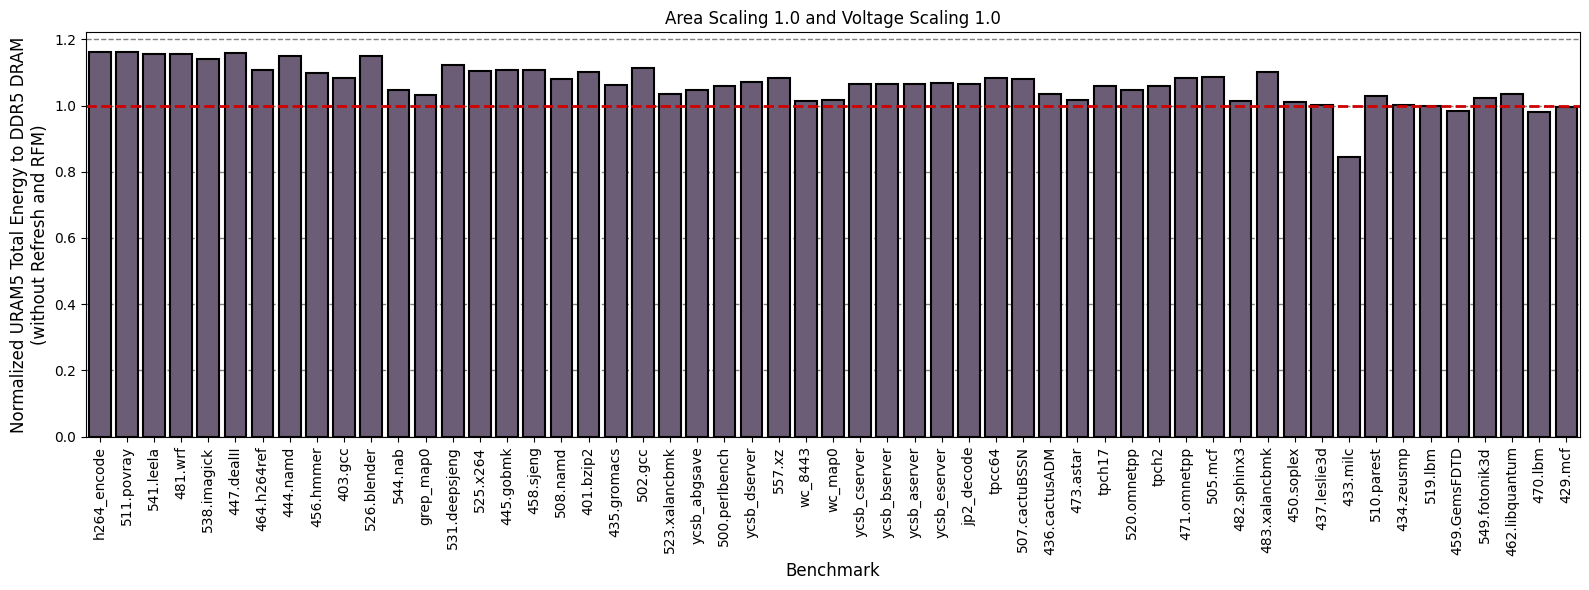

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

color_palette =['#6d597a', '#b56576', '#eaac8b']

uram5_df = sc_df[(sc_df['Device'] == 'URAM5' ) & (sc_df['Row Policy'] == 'OpenRowPolicy') & (sc_df['Area Scaling'] == 1.0) & (sc_df['Voltage Scaling'] == 1.0)].copy()
uram5_df.loc[:, 'Total Energy'] = uram5_df['Yaml'].apply(lambda x: x['MemorySystem']['DRAM']['total_energy'])
uram5_df = uram5_df[['Trace', 'Total Energy']]

ddr5_df = sc_df[(sc_df['Device'] == 'DDR5' ) & (sc_df['Row Policy'] == 'OpenRowPolicy') & (sc_df['Area Scaling'] == 1.0) & (sc_df['Voltage Scaling'] == 1.0)].copy()
ddr5_df.loc[:, 'RFM Energy']   = ddr5_df['Yaml'].apply(lambda x: x['MemorySystem']['DRAM']['total_rfm_energy'])
ddr5_df.loc[:, 'REF Energy']   = ddr5_df['Yaml'].apply(lambda x: x['MemorySystem']['DRAM']['total_ref_energy'])
ddr5_df.loc[:, 'Total Energy'] = ddr5_df['Yaml'].apply(lambda x: x['MemorySystem']['DRAM']['total_energy'])
ddr5_df.loc[:, 'Other Energy'] = ddr5_df['Total Energy'] - ddr5_df['RFM Energy'] - ddr5_df['REF Energy']
ddr5_df = ddr5_df[['Trace', 'Other Energy']]

uram5_df.loc[:, 'Normalized Total Energy'] = 0.0
for index, row in uram5_df.iterrows():
  uram5_df.at[index, 'Normalized Total Energy'] = row['Total Energy'] / ddr5_df[ddr5_df['Trace'] == row['Trace']]['Other Energy'].item()

#-------------------------------------------------------------------------------

plt.figure(figsize=(16, 6))

barplot = sns.barplot(data=uram5_df, x='Trace', y='Normalized Total Energy', edgecolor='black', 
                      linewidth=1.5, color=color_palette[0], zorder=2)

barplot.set_xlabel('Benchmark', fontsize=12)
barplot.set_ylabel('Normalized URAM5 Total Energy to DDR5 DRAM\n(without Refresh and RFM)', fontsize=12)
barplot.set_title(f'Area Scaling 1.0 and Voltage Scaling 1.0', fontsize=12)
barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=1, color='gray', zorder=0)

barplot.axhline(y=1.0, color='#d00000', linestyle='--', linewidth=2)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### to understand the correleation

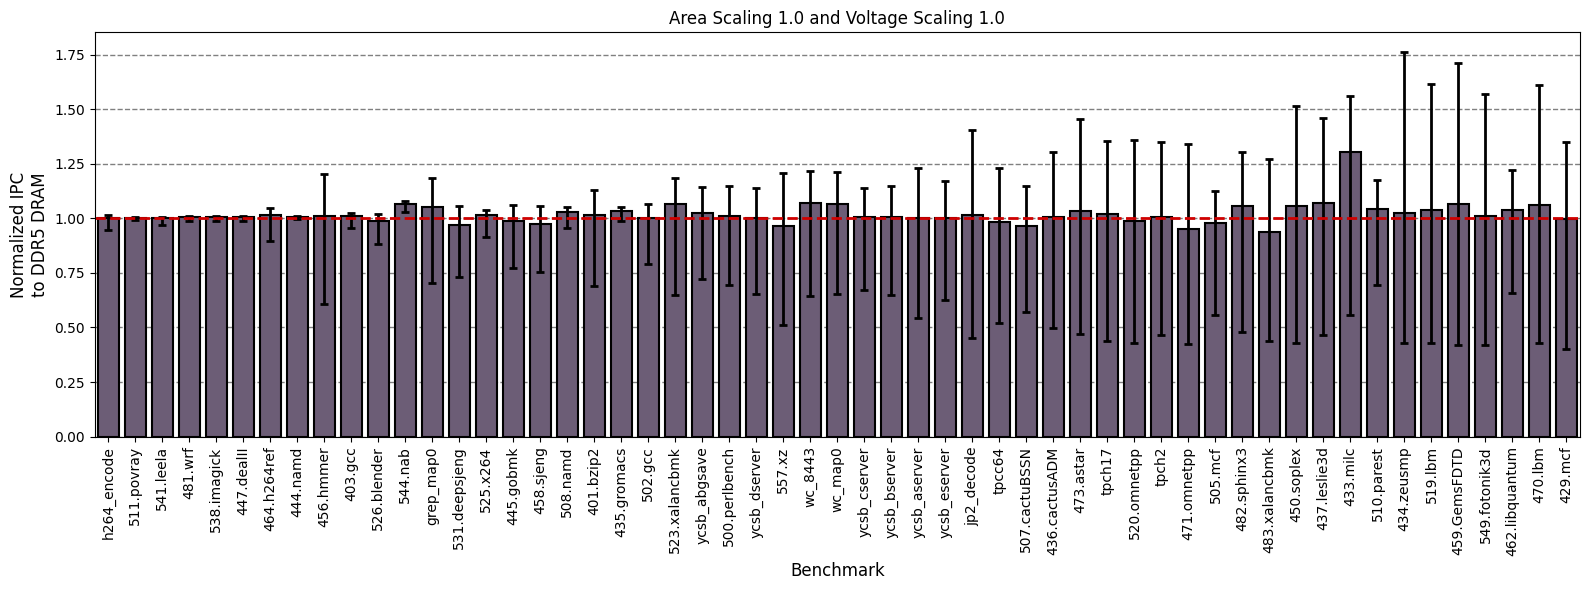

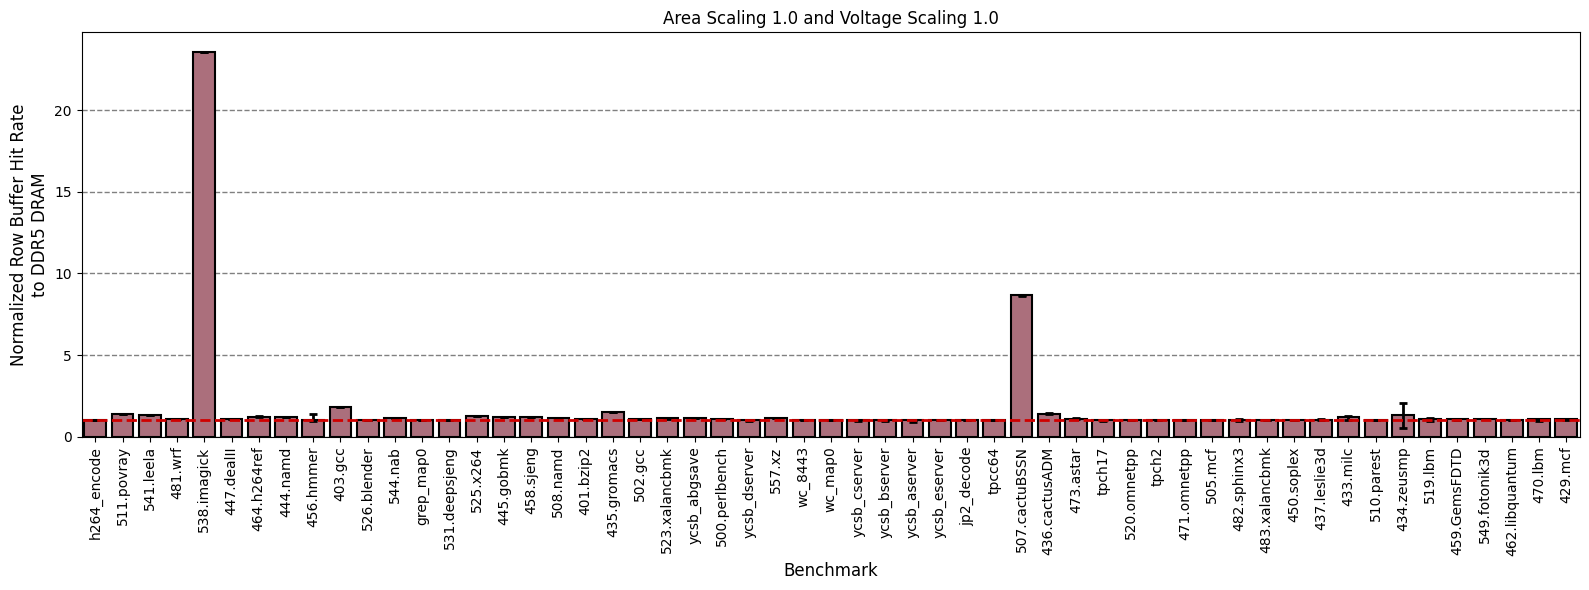

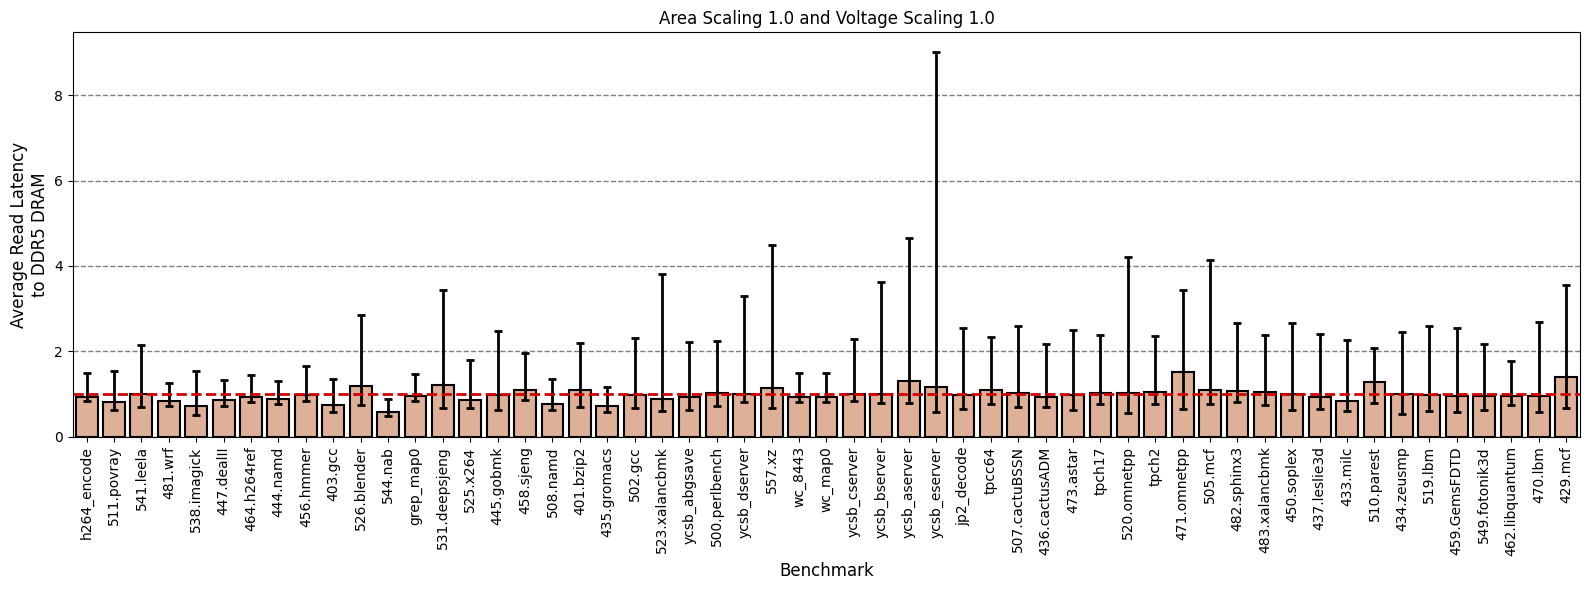

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

color_palette =['#6d597a', '#b56576', '#eaac8b']

sc_df.loc[:, 'IPC'] = sc_df['Yaml'].apply(lambda x: x['Frontend']['num_expected_insts'] / x['Frontend']['cycles_recorded_core_0'])
sc_df.loc[:, 'Row Buffer Hit Rate'] = sc_df['Yaml'].apply(lambda x: (x['MemorySystem']['Controller']['read_row_hits_0'] + x['MemorySystem']['Controller']['write_row_hits_0']) / 
                                                          (x['MemorySystem']['Controller']['read_row_hits_0'] + x['MemorySystem']['Controller']['write_row_hits_0'] +
                                                           x['MemorySystem']['Controller']['read_row_misses_0'] + x['MemorySystem']['Controller']['write_row_misses_0'] +
                                                           x['MemorySystem']['Controller']['read_row_conflicts_0'] + x['MemorySystem']['Controller']['write_row_conflicts_0']))
sc_df.loc[:, 'Average Read Latency'] = sc_df['Yaml'].apply(lambda x: x['MemorySystem']['Controller']['avg_read_latency_0'])

uram5_df = sc_df[(sc_df['Device'] == 'URAM5') & (sc_df['Row Policy'] == 'OpenRowPolicy')]
ddr5_df  = sc_df[(sc_df['Device'] == 'DDR5' ) & (sc_df['Row Policy'] == 'OpenRowPolicy') & (sc_df['Area Scaling'] == 1.0) & (sc_df['Voltage Scaling'] == 1.0)]

combined_df = pd.merge(uram5_df[['Trace', 'Area Scaling', 'Voltage Scaling', 'IPC', 'Row Buffer Hit Rate', 'Average Read Latency']],
                       ddr5_df[['Trace', 'Area Scaling', 'Voltage Scaling', 'IPC', 'Row Buffer Hit Rate', 'Average Read Latency']], on='Trace', suffixes=(' URAM5', ' DDR5'))
combined_df['Normalized IPC'] = combined_df['IPC URAM5'] / combined_df['IPC DDR5']
combined_df['Normalized Row Buffer Hit Rate'] = combined_df['Row Buffer Hit Rate URAM5'] / combined_df['Row Buffer Hit Rate DDR5']
combined_df['Average Read Latency'] = combined_df['Average Read Latency URAM5'] / combined_df['Average Read Latency DDR5']
combined_df = combined_df[['Trace', 'Area Scaling URAM5', 'Voltage Scaling URAM5', 'Normalized IPC', 'Normalized Row Buffer Hit Rate', 'Average Read Latency']]


error_df = combined_df.groupby('Trace').agg({
    'Normalized IPC': ['min', 'mean', 'max'],
    'Normalized Row Buffer Hit Rate': ['min', 'mean', 'max'],
    'Average Read Latency': ['min', 'mean', 'max']
}).reset_index()
error_df = error_df.set_index('Trace').reindex(combined_df['Trace'].drop_duplicates().values).reset_index()

df_filtered = combined_df[(combined_df['Area Scaling URAM5'] == 1.0) & 
                          (combined_df['Voltage Scaling URAM5'] == 1.0)]
# df_filtered = df_filtered.melt(id_vars=['Trace'], value_vars=['Normalized IPC', 'Normalized Row Buffer Hit Rate', 'Average Read Latency'], var_name='Metric', value_name='Value')

#-------------------------------------------------------------------------------

for idx, y_axis in enumerate(['Normalized IPC', 'Normalized Row Buffer Hit Rate', 'Average Read Latency']):
  plt.figure(figsize=(16, 6))

  barplot = sns.barplot(data=df_filtered, x='Trace', y=y_axis, edgecolor='black', 
                        linewidth=1.5, color=color_palette[idx], zorder=2)

  bar_positions = barplot.get_xticks()
  for i, row in error_df.iterrows():
    barplot.errorbar(x=bar_positions[i], y=row[(y_axis, 'mean')], 
                      yerr=[[abs(row[(y_axis, 'mean')] - row[(y_axis, 'min')])], [abs(row[(y_axis, 'max')] - row[(y_axis, 'mean')])]], 
                      fmt='none', color='black', capsize=3, capthick=2, elinewidth=2)

  barplot.set_xlabel('Benchmark', fontsize=12)
  barplot.set_ylabel(f'{y_axis}\nto DDR5 DRAM', fontsize=12)
  barplot.set_title(f'Area Scaling 1.0 and Voltage Scaling 1.0', fontsize=12)
  barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=1, color='gray', zorder=0)

  barplot.axhline(y=1.0, color='#d00000', linestyle='--', linewidth=2)
  barplot.set_xlim(-0.5, len(df_filtered['Trace'].unique()) - 0.5)

  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()

/tmp/ipykernel_8442/1492924584.py:66: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  agg_error_df = error_df.groupby('Trace Prefix').sum().reset_index()


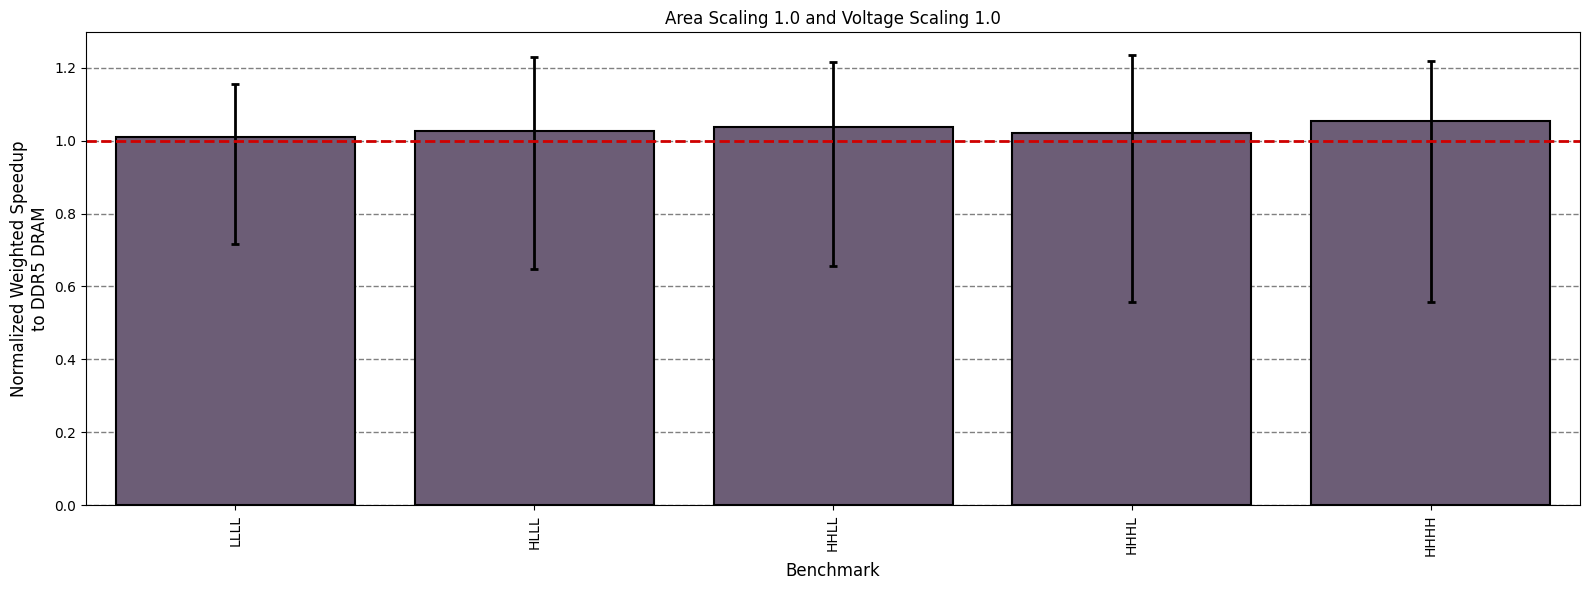

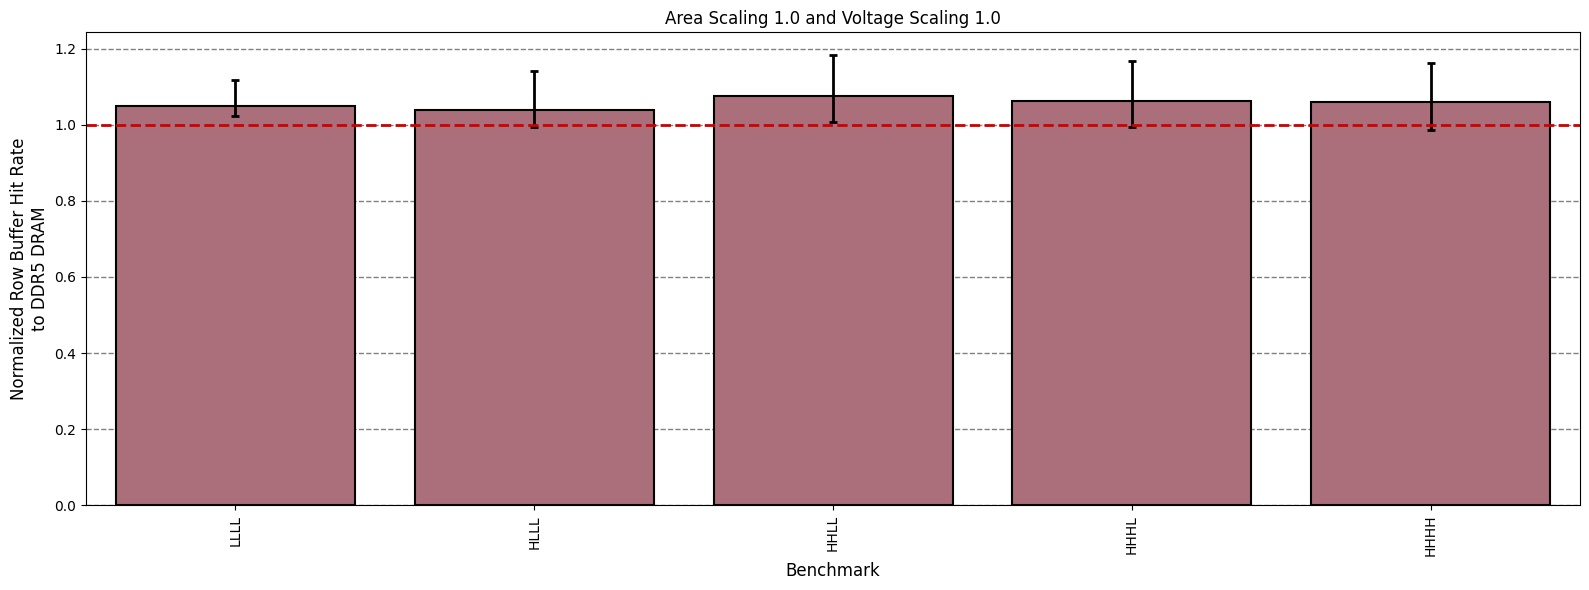

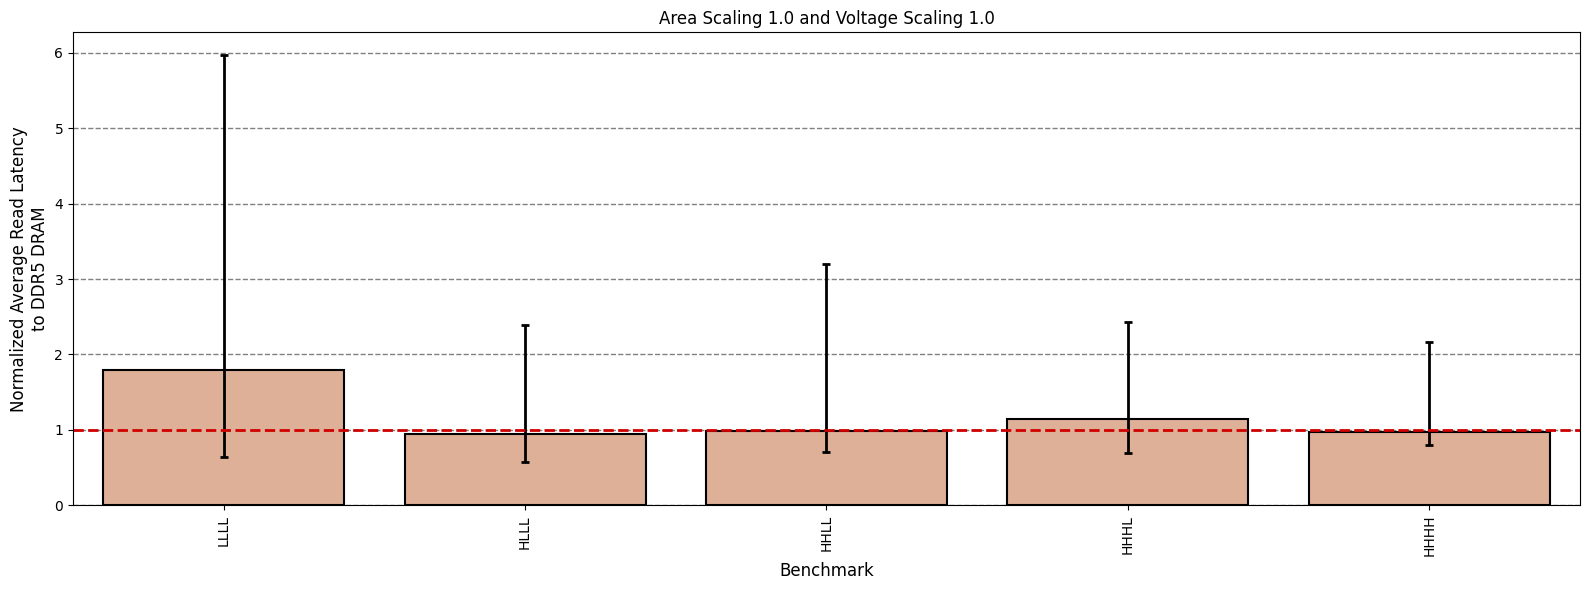

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

color_palette =['#6d597a', '#b56576', '#eaac8b']
trace_groups = {trace[0]: trace[1:] for trace in trace_list if trace[0].startswith(('H', 'L', 'M'))}

mc_df.loc[:, 'Weighted Speedup'] = 0.0
mc_df.loc[:, 'Row Buffer Hit Rate'] = mc_df['Yaml'].apply(lambda x: (x['MemorySystem']['Controller']['read_row_hits_0'] + x['MemorySystem']['Controller']['write_row_hits_0']) / 
                                                          (x['MemorySystem']['Controller']['read_row_hits_0'] + x['MemorySystem']['Controller']['write_row_hits_0'] +
                                                           x['MemorySystem']['Controller']['read_row_misses_0'] + x['MemorySystem']['Controller']['write_row_misses_0'] +
                                                           x['MemorySystem']['Controller']['read_row_conflicts_0'] + x['MemorySystem']['Controller']['write_row_conflicts_0']))
mc_df.loc[:, 'Average Read Latency'] = mc_df['Yaml'].apply(lambda x: x['MemorySystem']['Controller']['avg_read_latency_0'])

for index, rows in mc_df.iterrows():
  weighted_ipc = 0.0
  mc_trace_ipc = 0.0
  for idx, trace in enumerate(trace_groups[rows['Trace']]):
    conditions = (
      (sc_df['Device'] == 'DDR5') &
      (sc_df['Org'] == rows['Org']) &
      (sc_df['Timing'] == rows['Timing']) &
      (sc_df['Row Policy'] == rows['Row Policy']) &
      (sc_df['Refresh Manager'] == 'AllBank') &
      (sc_df['Voltage Scaling'] == 1.0) &
      (sc_df['Area Scaling'] == 1.0) &
      (sc_df['Trace'] == trace)
    )
    mc_trace_ipc = rows['Yaml']['Frontend']['num_expected_insts'] / rows['Yaml']['Frontend'][f'cycles_recorded_core_{idx}']
    sc_trace_ipc = sc_df[conditions]['Yaml'].item()['Frontend']['num_expected_insts'] / sc_df[conditions]['Yaml'].item()['Frontend']['cycles_recorded_core_0']
    weighted_ipc += mc_trace_ipc / sc_trace_ipc
  mc_df.at[index, 'Weighted Speedup'] = weighted_ipc


# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------

uram5_df = mc_df[(mc_df['Device'] == 'URAM5') & (mc_df['Row Policy'] == 'OpenRowPolicy')]
ddr5_df  = mc_df[(mc_df['Device'] == 'DDR5' ) & (mc_df['Row Policy'] == 'OpenRowPolicy') & (mc_df['Area Scaling'] == 1.0) & (mc_df['Voltage Scaling'] == 1.0)]


combined_df = pd.merge(uram5_df[['Trace', 'Area Scaling', 'Voltage Scaling', 'Weighted Speedup', 'Row Buffer Hit Rate', 'Average Read Latency']],
                       ddr5_df[['Trace', 'Area Scaling', 'Voltage Scaling', 'Weighted Speedup', 'Row Buffer Hit Rate', 'Average Read Latency']], on='Trace', suffixes=(' URAM5', ' DDR5'))
combined_df['Normalized Weighted Speedup'] = combined_df['Weighted Speedup URAM5'] / combined_df['Weighted Speedup DDR5']
combined_df['Normalized Row Buffer Hit Rate'] = combined_df['Row Buffer Hit Rate URAM5'] / combined_df['Row Buffer Hit Rate DDR5']
combined_df['Normalized Average Read Latency'] = combined_df['Average Read Latency URAM5'] / combined_df['Average Read Latency DDR5']
combined_df = combined_df[['Trace', 'Area Scaling URAM5', 'Voltage Scaling URAM5', 'Normalized Weighted Speedup', 'Normalized Row Buffer Hit Rate', 'Normalized Average Read Latency']]

base_df = combined_df[(combined_df['Area Scaling URAM5'] == 1.0) & (combined_df['Voltage Scaling URAM5'] == 1.0)].copy()

base_df.loc[:, 'Trace Prefix'] = base_df['Trace'].str.extract(r'([A-Za-z]+)', expand=False)
agg_base_df = base_df.groupby('Trace Prefix').sum().reset_index()
agg_base_df['Normalized Weighted Speedup'] =  agg_base_df['Normalized Weighted Speedup'] / 20 #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_base_df['Normalized Row Buffer Hit Rate'] =  agg_base_df['Normalized Row Buffer Hit Rate'] / 20 #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_base_df['Normalized Average Read Latency'] =  agg_base_df['Normalized Average Read Latency'] / 20 #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_base_df.sort_values(by='Trace Prefix', ascending=False, inplace=True)

error_df = combined_df.groupby('Trace').agg({
    'Normalized Weighted Speedup': ['min', 'mean', 'max'],
    'Normalized Row Buffer Hit Rate': ['min', 'mean', 'max'],
    'Normalized Average Read Latency': ['min', 'mean', 'max']
}).reset_index()
error_df = error_df.set_index('Trace').reindex(combined_df['Trace'].drop_duplicates().values).reset_index()

error_df.loc[:, 'Trace Prefix'] = error_df['Trace'].str.extract(r'([A-Za-z]+)', expand=False)
agg_error_df = error_df.groupby('Trace Prefix').sum().reset_index()
agg_error_df[('Normalized Weighted Speedup', 'max')] = agg_error_df[('Normalized Weighted Speedup', 'max')] / 20 #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_error_df[('Normalized Weighted Speedup', 'mean')] = agg_error_df[('Normalized Weighted Speedup', 'mean')] / 20 #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_error_df[('Normalized Weighted Speedup', 'min')] = agg_error_df[('Normalized Weighted Speedup', 'min')] / 20 #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_error_df[('Normalized Row Buffer Hit Rate', 'max')] = agg_error_df[('Normalized Row Buffer Hit Rate', 'max')] / 20 #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_error_df[('Normalized Row Buffer Hit Rate', 'mean')] = agg_error_df[('Normalized Row Buffer Hit Rate', 'mean')] / 20 #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_error_df[('Normalized Row Buffer Hit Rate', 'min')] = agg_error_df[('Normalized Row Buffer Hit Rate', 'min')] / 20 #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_error_df[('Normalized Average Read Latency', 'max')] = agg_error_df[('Normalized Average Read Latency', 'max')] / 20 #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_error_df[('Normalized Average Read Latency', 'mean')] = agg_error_df[('Normalized Average Read Latency', 'mean')] / 20 #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_error_df[('Normalized Average Read Latency', 'min')] = agg_error_df[('Normalized Average Read Latency', 'min')] / 20 #TODO: 20 IS HARDCODED, NEED A FIX ASAP
agg_error_df = agg_error_df.set_index('Trace Prefix').reindex(agg_base_df['Trace Prefix'].drop_duplicates().values).reset_index()

#-------------------------------------------------------------------------------

for idx, y_axis in enumerate(['Normalized Weighted Speedup', 'Normalized Row Buffer Hit Rate', 'Normalized Average Read Latency']):
  plt.figure(figsize=(16, 6))

  barplot = sns.barplot(data=agg_base_df, x='Trace Prefix', y=y_axis, edgecolor='black', 
                        linewidth=1.5, color=color_palette[idx], zorder=2)

  bar_positions = barplot.get_xticks()
  for i, row in agg_error_df.iterrows():
    barplot.errorbar(x=bar_positions[i], y=row[(y_axis, 'mean')], 
                      yerr=[[abs(row[(y_axis, 'mean')] - row[(y_axis, 'min')])], [abs(row[(y_axis, 'max')] - row[(y_axis, 'mean')])]], 
                      fmt='none', color='black', capsize=3, capthick=2, elinewidth=2)

  barplot.set_xlabel('Benchmark', fontsize=12)
  barplot.set_ylabel(f'{y_axis}\nto DDR5 DRAM', fontsize=12)
  barplot.set_title(f'Area Scaling 1.0 and Voltage Scaling 1.0', fontsize=12)
  barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=1, color='gray', zorder=0)

  barplot.axhline(y=1.0, color='#d00000', linestyle='--', linewidth=2)
  barplot.set_xlim(-0.5, len(agg_base_df['Trace Prefix'].unique()) - 0.5)

  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()